In [91]:
import numpy as np

np.random.seed(0)
class LayerDense:
    #weights  n_inputs  n_neurons
    #inputs   n_samples n_inputs
    #output   n_samples n_classes
    #dvalues  n_samples n_nuerons
    
    def __init__(self, n_inputs, n_neurons):
        self.weights = .01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
            
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbias = np.sum(dvalues, axis= 0, keepdims= True )
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        
class ActivationSigmoid:
    def forward(self, inputs):
        self.output = 1 / (1 + np.exp(-inputs))
        
    def backward(self, dvlaues):
        self.dinputs = self.output * (1 - self.output) * dvlaues
        

class ActivationReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <=0] = 0     
           
        

class ActivationSoftmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs,axis = 1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True) 
        
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalue)
            
            
                
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
    
        
class LossCategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_true)
        y_pred = np.clip(y_pred, 1e-7, 1)
        #for label encoded vlaues
        if len(y_true.shape) == 1:
            correct_proba = y_pred[range(samples), y_true]
        
        #for one hot encoded
        elif len(y_true.shape) == 2:
            correct_proba = np.sum(y_pred * y_true , axis=1)
        
        cross_entropy = -np.log(correct_proba)
        return cross_entropy
    
    def backward(self, y_true, y_hat):
        self.dinputs = - y_true / y_hat
        
        
        
class ActivationSoftmax_LossCategoricalCrossentropy():
    def __init__(self):
        self.activation = ActivationSoftmax()
        self.loss = LossCategoricalCrossentropy()
        
    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        
        return self.loss.calculate(self.output, y_true)
    
    def backward(self, y_pred, y_true):
        samples = len(y_pred)
        self.dinputs = y_pred.copy()
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples
        
                
class Optimizer_SGD():
    def __init__(self, learning_rate = 1.0, decay = 0, momentum = 0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.current_learning_rate = learning_rate   
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update(self):
        self.current_learning_rate = self.learning_rate *  (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, "weight_momentums"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_update = -self.current_learning_rate * layer.dweights + self.momentum * layer.weight_momentums
            layer.weight_momentums = weight_update
            
            bias_update = -self.current_learning_rate * layer.dbias + self.momentum * layer.bias_momentums
            layer.bias_momentums = bias_update
            
            layer.weights += weight_update
            layer.biases += bias_update
                
        else:
            layer.weights -= self.current_learning_rate * layer.dweights
            layer.biases -= self.current_learning_rate * layer.dbias
    
        
    def post_update(self):
        self.iterations += 1
        
        
        
class Optimizer_Adagrad():
    def __init__(self, learning_rate = 1.0, decay = 0,epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.decay = decay
        self.current_learning_rate = learning_rate   
        self.iterations = 0
        self.epsilon = epsilon
    
    def pre_update(self):
        self.current_learning_rate = self.learning_rate *  (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
            if not hasattr(layer, "weight_cashe"):
                layer.weight_cashe = np.zeros_like(layer.weights)
                layer.bias_cashe = np.zeros_like(layer.biases)
            
            layer.weight_cashe += layer.dweights**2
            layer.bias_cashe += layer.dbias**2
             
            layer.weights -= self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cashe) + self.epsilon)
            layer.biases -= self.current_learning_rate * layer.dbias / (np.sqrt(layer.bias_cashe) + self.epsilon)
            
        
    def post_update(self):
        self.iterations += 1
            
        
class Optimizer_RMSprob():
    def __init__(self, learning_rate = .001, decay = 0,epsilon = 1e-7, rho = .9):
        self.learning_rate = learning_rate
        self.decay = decay
        self.current_learning_rate = learning_rate   
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    def pre_update(self):
        self.current_learning_rate = self.learning_rate *  (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
            if not hasattr(layer, "weight_cashe"):
                layer.weight_cashe = np.zeros_like(layer.weights)
                layer.bias_cashe = np.zeros_like(layer.biases)
            
            layer.weight_cashe = self.rho * layer.weight_cashe + (1 - self.rho) * layer.dweights**2
            layer.bias_cashe = self.rho * layer.bias_cashe + (1-self.rho) * layer.dbias**2
            
            layer.weights -= self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cashe) + self.epsilon)
            layer.biases -= self.current_learning_rate * layer.dbias / (np.sqrt(layer.bias_cashe) + self.epsilon)
            
        
    def post_update(self):
        self.iterations += 1
        
        
        
class Optimizer_Adam():
    def __init__(self, learning_rate = .001, decay = 0,epsilon = 1e-7, beta1 = .9, beta2 = .999):
        self.learning_rate = learning_rate
        self.decay = decay
        self.current_learning_rate = learning_rate   
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
    
    def pre_update(self):
        self.current_learning_rate = self.learning_rate *  (1. / (1. + self.decay * self.iterations))
            
    def update_params(self, layer):
            if not hasattr(layer, "weight_cashe"):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                layer.weight_cashe = np.zeros_like(layer.weights)
                layer.bias_cashe = np.zeros_like(layer.biases)
                
            layer.weight_momentums = self.beta2 * layer.weight_momentums + (1 - self.beta1) * layer.dweights
            layer.bias_momentums = self.beta2 * layer.bias_momentums + (1 - self.beta1) * layer.dbias
            
            weights_momentums_corrected = layer.weight_momentums / (1 - self.beta1 ** (self.iterations + 1))
            bias_momentums_corrected = layer.bias_momentums / (1 - self.beta1 ** (self.iterations + 1))
            
            layer.weight_cashe = self.beta2 * layer.weight_cashe + (1 - self.beta2) * layer.dweights**2
            layer.bias_cashe = self.beta2 * layer.bias_cashe + (1-self.beta2) * layer.dbias**2
            
            weight_cashe_corrected = layer.weight_cashe / (1 - self.beta2 ** (self.iterations + 1))
            bias_cashe_corrected = layer.bias_cashe / (1 - self.beta2 ** (self.iterations + 1))
            
            
            layer.weights -= self.current_learning_rate * weights_momentums_corrected / (np.sqrt(weight_cashe_corrected) + self.epsilon)
            layer.biases -= self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cashe_corrected) + self.epsilon)
            
        
    def post_update(self):
        self.iterations += 1

In [92]:
import pandas as pd


data = pd.read_csv("spiral_data.csv")
X = data.drop("y", axis = 1)
y = data["y"]


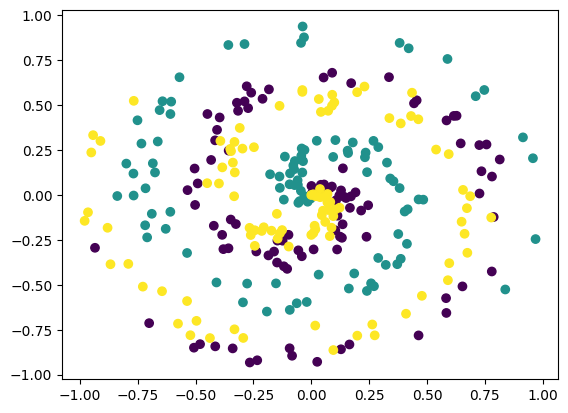

In [93]:
import matplotlib.pyplot as plt
plt.scatter(X["feature 1"], X["feature 2"], c = y)

In [94]:
dense1 = LayerDense(2, 64)
activation1 = ActivationReLU()
dense2 = LayerDense(64, 3)
loss_activation = ActivationSoftmax_LossCategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=.01, decay= 1e-5)

for epoch in range(10001):
    #forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y)
    
    predictions = np.argmax(loss_activation.output, axis=1)
    accuracy = np.mean(predictions == y)
    
    if epoch %100 == 0:
        print(f'epoch: {epoch}, '+
              f'accuracy: {accuracy:.3f}, '+
              f'loss: {loss:.3f}')
    
    #backward pass
    loss_activation.backward(loss_activation.output, y)    
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update()
    
    

epoch: 0, accuracy: 0.377, loss: 1.099
epoch: 100, accuracy: 0.717, loss: 0.713
epoch: 200, accuracy: 0.860, loss: 0.323
epoch: 300, accuracy: 0.903, loss: 0.196
epoch: 400, accuracy: 0.927, loss: 0.156
epoch: 500, accuracy: 0.920, loss: 0.138
epoch: 600, accuracy: 0.943, loss: 0.118
epoch: 700, accuracy: 0.950, loss: 0.105
epoch: 800, accuracy: 0.963, loss: 0.097
epoch: 900, accuracy: 0.957, loss: 0.090
epoch: 1000, accuracy: 0.963, loss: 0.099
epoch: 1100, accuracy: 0.957, loss: 0.100
epoch: 1200, accuracy: 0.960, loss: 0.098
epoch: 1300, accuracy: 0.967, loss: 0.088
epoch: 1400, accuracy: 0.963, loss: 0.077
epoch: 1500, accuracy: 0.970, loss: 0.070
epoch: 1600, accuracy: 0.957, loss: 0.075
epoch: 1700, accuracy: 0.950, loss: 0.106
epoch: 1800, accuracy: 0.947, loss: 0.118
epoch: 1900, accuracy: 0.947, loss: 0.132
epoch: 2000, accuracy: 0.957, loss: 0.121
epoch: 2100, accuracy: 0.973, loss: 0.105
epoch: 2200, accuracy: 0.960, loss: 0.098
epoch: 2300, accuracy: 0.957, loss: 0.096
epoc